In [2]:
import numpy as np
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import matplotlib.pylab as plt
import os
import time
import torch
import sys
sys.path.insert(0, 'code')
from Utils_inverse_prob import *
from network import *
from algorithm_inv_prob import *

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from PIL import Image
import random


import numpy as np
import torch.nn as nn
import torch
import torch.optim as optim
import argparse

from tqdm import tqdm



In [4]:
%matplotlib inline

In [5]:

def def_args(grayscale=False, num_kernels = 64):
    '''
    @ grayscale: if True, number of input and output channels are set to 1. Otherwise 3
    @ training_data: models provided in here have been trained on {BSD400, mnist, BSD300}
    @ training_noise: standard deviation of noise during training the denoiser
    '''
    parser = argparse.ArgumentParser(description='BF_CNN_color')
    parser.add_argument('--dir_name', default= '../noise_range_')
    parser.add_argument('--kernel_size', default= 3)
    parser.add_argument('--padding', default= 1)
    parser.add_argument('--num_kernels', default= num_kernels)
    parser.add_argument('--num_layers', default= 20)
    if grayscale is True:
        parser.add_argument('--num_channels', default= 1)
    else:
        parser.add_argument('--num_channels', default= 3)

    args = parser.parse_args('')
    return args



In [6]:
class BF_CNN(nn.Module):

    def __init__(self, args):
        super(BF_CNN, self).__init__()

        self.padding = args.padding
        self.num_kernels = args.num_kernels
        self.kernel_size = args.kernel_size
        self.num_layers = args.num_layers
        self.num_channels = args.num_channels

        self.conv_layers = nn.ModuleList([])
        self.running_sd = nn.ParameterList([])
        self.gammas = nn.ParameterList([])

        # self.conv_layers.append(PrintShape())
        self.conv_layers.append(nn.Conv2d(self.num_channels,self.num_kernels, self.kernel_size, padding=self.padding , bias=False))

        for l in range(1,self.num_layers-1):
            # self.conv_layers.append(PrintShape())
            self.conv_layers.append(nn.Conv2d(self.num_kernels ,self.num_kernels, self.kernel_size, padding=self.padding , bias=False))
            self.running_sd.append( nn.Parameter(torch.ones(1,self.num_kernels,1,1), requires_grad=False) )
            g = (torch.randn( (1,self.num_kernels,1,1) )*(2./9./64.)).clamp_(-0.025,0.025)
            self.gammas.append(nn.Parameter(g, requires_grad=True) )

        self.conv_layers.append(nn.Conv2d(self.num_kernels,self.num_channels, self.kernel_size, padding=self.padding , bias=False))



    def forward(self, x):
        relu = nn.ReLU(inplace=True)
        x = relu(self.conv_layers[0](x))
        for l in range(1,self.num_layers-1):
            x = self.conv_layers[l](x)
            # BF_BatchNorm
            sd_x = torch.sqrt(x.var(dim=(0,2,3) ,keepdim = True, unbiased=False)+ 1e-05)

            if self.conv_layers[l].training:
                x = x / sd_x.expand_as(x)
                self.running_sd[l-1].data = (1-.1) * self.running_sd[l-1].data + .1 * sd_x
                x = x * self.gammas[l-1].expand_as(x)

            else:
                x = x / self.running_sd[l-1].expand_as(x)
                x = x * self.gammas[l-1].expand_as(x)

            x = relu(x)

        x = self.conv_layers[-1](x)

        return x




In [7]:

class RandomCropMNISTDataset(Dataset):
    def __init__(self, root, transform=None, crop_size=24, num_crops=1, max_std=0.1, train=True):
        self.mnist_dataset = datasets.MNIST(root=root, train=train, transform=None, download=True)
        self.transform = transform
        self.crop_size = crop_size
        self.num_crops = num_crops
        self.max_std = max_std

    def __len__(self):
        return len(self.mnist_dataset)

    def __getitem__(self, index):
        image, label = self.mnist_dataset[index]

        # Perform random crops
        crops = []
        for _ in range(self.num_crops):
            x = random.randint(0, image.size[0] - self.crop_size)
            y = random.randint(0, image.size[1] - self.crop_size)
            cropped_image = image.crop((x, y, x + self.crop_size, y + self.crop_size))

            # Apply transformations
            if self.transform is not None:
                cropped_image = self.transform(cropped_image)

            # Add Gaussian noise to the cropped image
            std_dev = random.uniform(0, self.max_std)
            noised_image = self.add_gaussian_noise(cropped_image, std_dev)

            crops.append((cropped_image, noised_image, label))

        return crops

    def add_gaussian_noise(self, image, std_dev):
        noise = torch.randn_like(image) * std_dev
        noised_image = image + noise
        return noised_image

# # Example usage:
# # Define the transform to normalize and convert to PyTorch tensor
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# root = 'C:/Users/ANT/Documents/info/IIN_universal_inverse_problem/test_images/grayscale/mnist'
# # Create the dataset
# mnist_dataset = RandomCropMNISTDataset(root=root, transform=transform, crop_size=24, num_crops=5, max_std=0.1, train=True)

# # Access a sample from the dataset
# sample = mnist_dataset[0]




In [8]:
%%script false --no-raise-error
# Define the Mean Squared Error (MSE) loss
criterion = nn.MSELoss()

# Instantiate the model, optimizer, and dataset
args = def_args(grayscale=True)
model = BF_CNN(args)
optimizer = optim.Adam(model.parameters(), lr=0.001)
transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,))
])

crop_size = 24

mnist_dataset = RandomCropMNISTDataset(root='./data', transform=transform, crop_size=crop_size, num_crops=1, max_std=0.4, train=True)

# DataLoader for batching and shuffling
dataloader = DataLoader(mnist_dataset, batch_size=64, shuffle=True)

# Training loop
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(num_epochs):
    running_loss = 0.0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_clean, batch_noised, _ = batch[0]
        batch_clean, batch_noised = batch_clean.to(device), batch_noised.to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch_noised)

        # Compute the MSE loss
        loss = criterion(outputs, batch_clean)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")

print("Training complete.")

torch.save(model.state_dict(), f'bf_cnn_mnist_trained_with_crops_{crop_size}x{crop_size}_{num_epochs}.pth')



Couldn't find program: 'false'


In [124]:
args = def_args(grayscale=True,num_kernels=64)
# Initialize the model, loss function, and optimizer
model = BF_CNN(args)
model.load_state_dict(torch.load('code/bf_cnn_mnist_trained_with_crops_24x24.pth',map_location=torch.device('cpu')))
model.eval();

In [125]:
def plot_side_by_side(arrays):
    num_arrays = len(arrays)

    fig, axes = plt.subplots(1, num_arrays, figsize=(15, 5))

    cmap='viridis'

    if arrays[0].ndim == 2:
        cmap ='Greys'


    for i in range(num_arrays):
        axes[i].imshow(arrays[i], cmap=cmap)  # Change the cmap to your preferred colormap
        axes[i].axis('off')
        # axes[i].set_title(f'Array {i + 1}')

    plt.show()

# # Example usage:
# # Create 5 example arrays (you can replace these with your actual arrays)
# array1 = np.random.rand(100, 100)
# array2 = np.random.rand(100, 100)
# array3 = np.random.rand(100, 100)
# array4 = np.random.rand(100, 100)
# array5 = np.random.rand(100, 100)

# # Plot the arrays side by side
# plot_side_by_side([array1, array2, array3, array4, array5])

In [132]:
def simple_synthesis(denoiser, greyscale, h=0.1, gamma = 0., iter = 25):
    if greyscale:
        C = 1
    else:
        C = 3 
    y = torch.randn((1,C,28,28)) + .5

    imgs = [y.clone().transpose(-3,-2).transpose(-2,-1).squeeze().detach().numpy()]
    for i in range(iter):
        y += h*(denoiser(y) - y)   +  (gamma *torch.randn_like(y) ) / (i+1)

        if i % 5 == 0:
            imgs.append(y.clone().transpose(-3,-2).transpose(-2,-1).squeeze().detach().numpy())
        # plt.imshow(y.squeeze().detach().numpy())
        # plt.show()
    plot_side_by_side(imgs)

In [133]:
simple_synthesis(model,greyscale=True, iter = 30)

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [134]:
y = torch.randn((1,1,28,28)) + .5
for i in range(20):
    y += 0.2*(model(y) - y)   +  (0.01 *torch.randn_like(y) )
    plt.imshow(y.transpose(-3,-2).transpose(-2,-1).squeeze().detach().numpy(),cmap='Greys')
plt.show()

RuntimeError: Given groups=1, weight of size [64, 3, 3, 3], expected input[1, 1, 28, 28] to have 3 channels, but got 1 channels instead

In [ ]:
import os
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset
import random

class RandomCropCustomDataset(Dataset):
    def __init__(self, root, transform=None, crop_size=24, num_crops=1, max_std=0.1):
        self.root = root
        self.transform = transform
        self.crop_size = crop_size
        self.num_crops = num_crops
        self.max_std = max_std

        # Get the list of image files in the specified folder
        self.image_files = [f for f in os.listdir(root) if f.lower().endswith(('png', 'jpg', 'jpeg', 'gif', 'bmp'))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        # Load the image
        image_path = os.path.join(self.root, self.image_files[index])
        image = Image.open(image_path).convert('RGB')

        # Perform random crops
        crops = []
        for _ in range(self.num_crops):
            x = random.randint(0, image.size[0] - self.crop_size)
            y = random.randint(0, image.size[1] - self.crop_size)
            cropped_image = image.crop((x, y, x + self.crop_size, y + self.crop_size))

            # Apply transformations
            if self.transform is not None:
                cropped_image = self.transform(cropped_image)

            # Add Gaussian noise to the cropped image
            std_dev = random.uniform(0, self.max_std)
            noised_image = self.add_gaussian_noise(cropped_image, std_dev)

            crops.append((cropped_image, noised_image))

        return crops

    def add_gaussian_noise(self, image, std_dev):
        noise = torch.randn_like(image) * std_dev
        noised_image = image + noise
        return noised_image

# Example usage:
# Define the transform to normalize and convert to PyTorch tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create the dataset
custom_dataset = RandomCropCustomDataset(root='test_images\color\BSD100', transform=transform, crop_size=24, num_crops=5, max_std=0.1)

# Access a sample from the dataset
sample = custom_dataset[0]


In [135]:
args = def_args(grayscale=False,num_kernels=64)
# Initialize the model, loss function, and optimizer
model = BF_CNN(args)
model.load_state_dict(torch.load('code/bf_cnn_trained_with_crops_60x60_768.pth',map_location=torch.device('cpu')))
model.eval();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


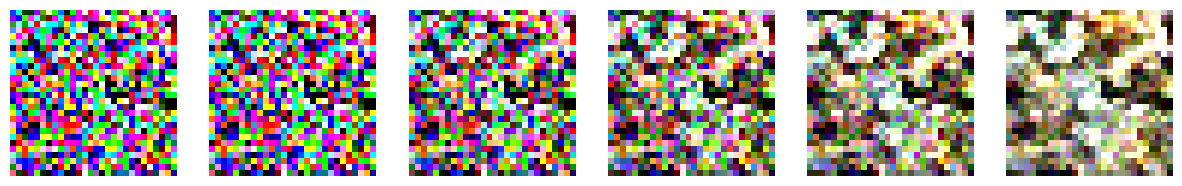

In [149]:
simple_synthesis(model,False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

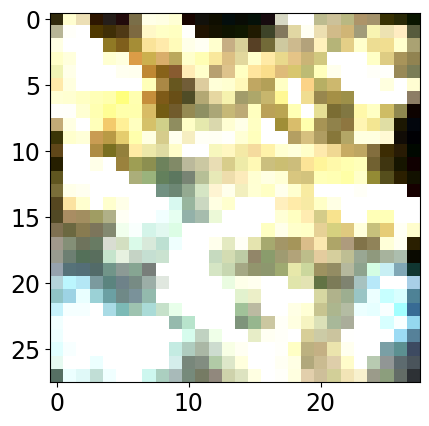

In [137]:
y = torch.randn((1,3,28,28)) + .5
for i in range(20):
    y += 0.2*(model(y) - y)   +  (0.01 *torch.randn_like(y) )
    plt.imshow(y.transpose(-3,-2).transpose(-2,-1).squeeze().detach().numpy(),cmap='Greys')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

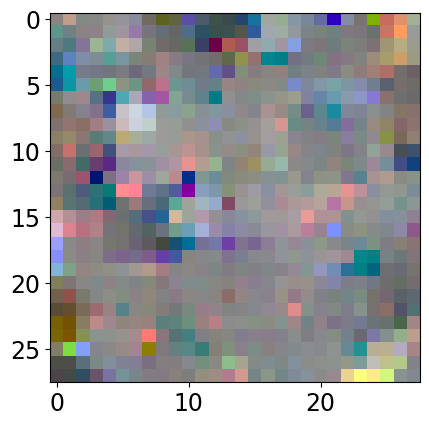

In [138]:
from skimage.restoration import denoise_tv_chambolle
y = np.random.randn(1,3,28,28) + .5
for i in range(30):
    y += 0.2*( denoise_tv_chambolle(y) - y)   +  (0.01 * np.random.randn(1,3,28,28) )
    plt.imshow(np.transpose(y.squeeze(),(1,2,0)),cmap='Greys')
plt.show()